In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np
from sklearn import model_selection
import random

#### Реализовать оценку Out-of-Bag ошибок для каждого из деревьев леса

In [2]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [3]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    out_of_bag_idx = [[i for i in range(data.shape[0])] for el in range(N)]
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            if sample_index in out_of_bag_idx[i]:
                out_of_bag_idx[i].remove(sample_index)
        bootstrap.append((b_data, b_labels))

    return bootstrap, out_of_bag_idx

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [4]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)



def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [5]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, out_of_bag_idx = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, out_of_bag_idx

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return np.array(voted_predictions)

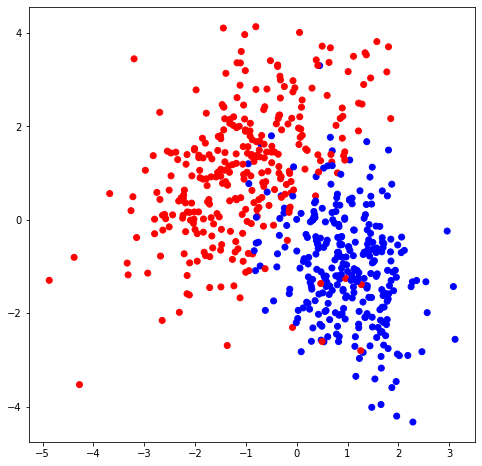

In [6]:
classification_data, classification_labels = datasets.make_classification(n_samples=600,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [7]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [8]:
def accuracy_metric(actual, predicted):
    return np.sum(actual==predicted)/len(actual)

def balanced_accuracy_metric(actual, predicted):
    true_predicted=(actual==predicted).astype(int)
    sensitivity=np.sum(actual*true_predicted)/np.sum(actual==1)
    specificity=np.sum((1-actual)*true_predicted)/np.sum(actual==0)
    return 0.5*(sensitivity+specificity)

In [9]:
def oob_error(forest, oob_idx, data, labels):
    oob_dict = {} # индексы и ответы всех деревьев, которые не обучались на данном признаке
    each_tree_error = []
    for tree in range(len(forest)):
        each_tree_error.append(np.sum(predict(data[oob_idx[tree]], forest[tree])!=labels[oob_idx[tree]]) /len(oob_idx[tree]))
        # вычисление oob_error для всех деревьев, которые не обучались на данном признаке
        tmp_list = [[el] for el in predict(data[oob_idx[tree]], forest[tree])]
        tmp_dict = dict(zip(oob_idx[tree], tmp_list))
        for el in tmp_dict.keys():
            if el not in oob_dict.keys():
                oob_dict[el] = tmp_dict[el]
            else:
                oob_dict[el].append(*tmp_dict[el])
    for k in oob_dict.keys():
        oob_dict[k] = max(oob_dict[k], key=oob_dict[k].count)
    total_oob_err = np.sum(list(oob_dict.values())!=train_labels[list(oob_dict.keys())]) / len(oob_dict)
    return total_oob_err, each_tree_error
    

In [10]:
n_trees = 1
my_forest, oob_idx = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest, train_data)
test_answers = tree_vote(my_forest, test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
tot_error, tree_error = oob_error(my_forest, oob_idx, train_data, train_labels)
print(f'out of bag error случайного леса из {n_trees} деревьев на обучающей выборке: {tot_error:.3f}')
for num, el in enumerate(tree_error, 1):
    print(f'oob error дерева {num} = {el:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 0.983
Точность случайного леса из 1 деревьев на тестовой выборке: 0.939
out of bag error случайного леса из 1 деревьев на обучающей выборке: 0.044
oob error дерева 1 = 0.044


In [13]:
n_trees = 5
my_forest, oob_idx = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest, train_data)
test_answers = tree_vote(my_forest, test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
tot_error, tree_error = oob_error(my_forest, oob_idx, train_data, train_labels)
print(f'out of bag error случайного леса из {n_trees} деревьев на обучающей выборке: {tot_error:.3f}')
for num, el in enumerate(tree_error, 1):
    print(f'oob error дерева {num} = {el:.3f}')

Точность случайного леса из 5 деревьев на обучающей выборке: 0.995
Точность случайного леса из 5 деревьев на тестовой выборке: 0.944
out of bag error случайного леса из 5 деревьев на обучающей выборке: 0.052
oob error дерева 1 = 0.053
oob error дерева 2 = 0.055
oob error дерева 3 = 0.080
oob error дерева 4 = 0.062
oob error дерева 5 = 0.032
